In [1]:
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
from tensorflow.nn import convolution

from celluloid import Camera
from matplotlib import animation, rc
from IPython.display import HTML
from IPython.display import clear_output
from time import time

In [17]:
N = 1000
dt = 0.001
h = 1 / N

In [18]:
_U = np.zeros(shape=(N, N, 2))
_I = np.zeros(shape=(N, N, 2))
_B = np.zeros(shape=(N, N, 1))
_p = np.zeros(shape=(N, N, 1))

_R = 10000 * np.ones(shape=(N, N, 1))
_eps = np.ones(shape=(N, N, 1))
_mu = np.ones(shape=(N, N, 1))

In [19]:
X = np.array([[0, 0, 0], [1, -1, 0],[0, 0, 0]])
Y = np.array([[0, 1, 0], [0, -1, 0],[0, 0, 0]])
_continuity_filter = np.stack([X, Y]).reshape((2, 3, 3, 1)).transpose(1,2,0,3)

In [20]:
X = np.array([[0, 0, 0], [0, 1, 0],[0, -1, 0]])
Y = np.array([[0, 0, 0], [0, -1, 1],[0, 0, 0]])
_faraday_filter = np.stack([X, Y]).reshape((2, 3, 3, 1)).transpose(1,2,0,3) / h ** 2

In [21]:
X = np.array([[0, 1, 0], [0, -1, 0],[0, 0, 0]])
Y = np.array([[0, 0, 0], [-1, 1, 0],[0, 0, 0]])
_ampere_filter = np.stack([X, Y]).reshape((2, 3, 3, 1)).transpose(1,2,3,0) * h

In [22]:
Y

array([[ 0,  0,  0],
       [-1,  1,  0],
       [ 0,  0,  0]])

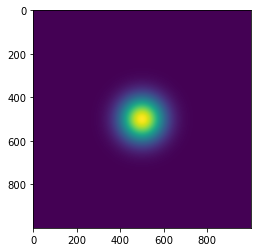

In [23]:
x = np.linspace(0, 10, N)
mesh = np.stack(np.meshgrid(x, x))

_B = np.exp(-np.sum(np.square((mesh-np.array([5,5]).reshape((2,1,1)))), axis=0))

plt.imshow(_B)

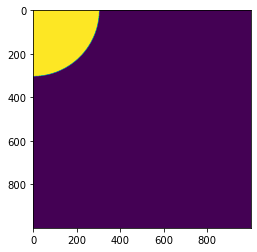

In [24]:
x = np.linspace(0, 10, N)
mesh = np.stack(np.meshgrid(x, x))
U = np.exp(-np.sum(np.square(mesh), axis=0))
plt.imshow(U>0.0001)
_R[U>0.0001]=0.1

In [25]:
_continuity_filter[:,:,0,0]

array([[ 0,  0,  0],
       [ 1, -1,  0],
       [ 0,  0,  0]])

In [26]:
_continuity_filter[:,:,1,0]

array([[ 0,  1,  0],
       [ 0, -1,  0],
       [ 0,  0,  0]])

In [27]:
faraday_filter = tf.constant(_faraday_filter, name='faraday_filter', dtype=tf.float64)
ampere_filter = tf.constant(_ampere_filter, name='ampere_filter', dtype=tf.float64)
continuity_filter = tf.constant(_continuity_filter, name='continuity_filter', dtype=tf.float64)

eps = tf.constant(_eps.reshape((1, N, N, 1)), name='dielectricity', dtype=tf.float64)
mu = tf.constant(_mu.reshape((1, N, N, 1)), name='permitivity', dtype=tf.float64)
R = tf.constant(_R.reshape((1, N, N, 1)), name='resistance', dtype=tf.float64)
U = tf.Variable(_U.reshape((1, N, N, 2)), name='e_field', dtype=tf.float64)
I = tf.Variable(_I.reshape((1, N, N, 2)), name='current', dtype=tf.float64)
B = tf.Variable(_B.reshape((1, N, N, 1)), name='b_field', dtype=tf.float64)
p = tf.Variable(_p.reshape((1, N, N, 1)), name='charge_density', dtype=tf.float64)

In [44]:
class cam():
    
    def __init__(self, ):
        self.fig, self.axs = plt.subplots(2, 2)
        self.camera = Camera(self.fig)
        
    def plot(self, rp, i, v, b):
        self.axs[0, 0].imshow(rp)
        self.axs[0, 0].set_title('resistance/charge density')
        self.axs[0, 1].quiver(np.linspace(0,10,50),np.linspace(0,10,50), i[::20,::20,0], i[::20,::20,1], scale=1)
        self.axs[0, 1].set_title('current')
        self.axs[1, 0].imshow(b, vmin=-1, vmax=1)
        self.axs[1, 0].set_title('magnetic field')
        self.axs[1, 1].quiver(np.linspace(0,10,50),np.linspace(0,10,50), v[::20,::20,0], v[::20,::20,1], scale=1)
        self.axs[1, 1].set_title('electric field')
        self.fig.set_figheight(10)
        self.fig.set_figwidth(10)
        self.camera.snap()
        

In [45]:
tt = time()
for jter in range(1000):
    I = U / R
    dB = convolution(U, filters=faraday_filter, padding='SAME')
    dp = convolution(I, filters=continuity_filter, padding='SAME')
    dU = (convolution(B, filters=ampere_filter, padding='SAME') / eps / mu - I / eps)

    U.assign_add(dU * dt)
    B.assign_add(dB * dt)
    p.assign_add(dp * dt)
print(time() - tt)

12.362885236740112


In [46]:
np.max(dU.numpy()[0, :, :, 0])

4.032344811211754e-06

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


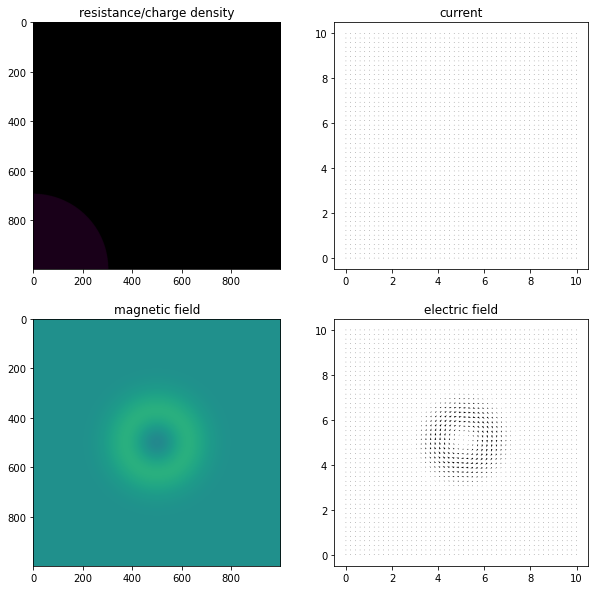

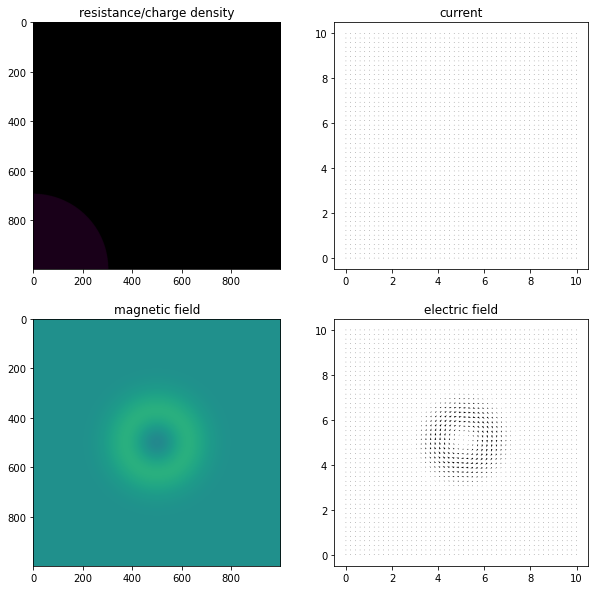

In [47]:
r = np.squeeze(R.numpy())
_p = np.squeeze(p.numpy())
rp = np.stack([r,_p,r]).transpose(2,1,0)
rp = (255*rp).astype(np.int8)
j = tf.squeeze(I).numpy()
cc = cam()
cc.plot(np.flipud(rp), j / h, tf.squeeze(U).numpy() / h, np.flipud(tf.squeeze(B).numpy()))
cc.fig

In [ ]:
#%%capture
cc = cam()
for jter in range(400000):
    I = U / R
    dB = convolution(U, filters=faraday_filter, padding='SAME')
    dp = convolution(I, filters=continuity_filter, padding='SAME')
    dU = (convolution(B, filters=ampere_filter, padding='SAME') / eps / mu - I / eps)

    U.assign_add(dU * dt)
    B.assign_add(dB * dt)
    p.assign_add(dp * dt)
    if jter % 1000 ==0:
        print(jter)
        r = np.squeeze(R.numpy())
        _p = np.squeeze(p.numpy())
        rp = np.stack([r,_p,r]).transpose(2,1,0)
        rp = (255*rp).astype(np.int8)
        j = tf.squeeze(I).numpy()
        cc.plot(np.flipud(rp), j, tf.squeeze(U).numpy(), np.flipud(tf.squeeze(B).numpy()))
anim = cc.camera.animate(blit=True)
clear_output()

In [ ]:
HTML(anim.to_html5_video())

In [ ]:
        fig, axs = plt.subplots(2, 2)

        camera = Camera(fig)
        

        plt.figure(figsize=(60, 60))
        axs[0, 0].imshow(rp)


In [ ]:
fig.show()